<!-- ![](./header.png) -->
<img src="./header.png",width=100%>

# Measuring Time Delays of Sprinkled Lensed Quasar Systems in CosmoDC2 with PyCS

*Ji Won Park (jiwoncpark)*

Write abstract here.

Introduction
============

<Explain what Sprinkler does> <Explain what we want to verify and validate> Sprinkled lensed quasar systems in CosmoDC2, 
<Say we only analyze a small sample here -- a quad and two doubles>

Method
======

Write about your methods here! Or change the sections to whatever you want!

In [9]:
from __future__ import absolute_import, division, print_function

import pycs
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
joined_df = pd.read_csv('joined_sprinkled.csv')
#joined_df.set_index(['galaxy_id', 'uniqueId']).head()
joined_df.query("uniqueId==338704312845429").head()

,uniqueId,obshistid,mag,galaxy_id,ra,dec,redshift,truth_galaxy_id,truth_redshift,magNorm,agn_tau,t0Delay,agn_sfu,agn_sfg,agn_sfr,agn_sfi,agn_sfz,agn_sfy,mjd,filter,fiveSigmaDepth,flux,flux_err,mag_err,flux_perband_avg,flux_overall_avg,whitening_offset
1282,338704312845429,230,25.643508,33076593,53.05169,-28.086299,0.62,330765930513,0.62,25.492465,153.8,7.144,0.6818,0.7161,0.703,0.5242,0.447,0.4438,59580.139555,r,24.083783,0.055284,0.249432,6.438057,0.054566,0.067784,-0.013219
1283,338704312845429,181866,25.603015,33076593,53.05169,-28.086299,0.62,330765930513,0.62,25.492465,153.8,7.144,0.6818,0.7161,0.703,0.5242,0.447,0.4438,59821.274782,r,24.149110,0.057384,0.150792,3.706929,0.054566,0.067784,-0.013219
1284,338704312845429,181898,25.602955,33076593,53.05169,-28.086299,0.62,330765930513,0.62,25.492465,153.8,7.144,0.6818,0.7161,0.703,0.5242,0.447,0.4438,59821.289313,r,24.100863,0.057388,0.073923,1.817126,0.054566,0.067784,-0.013219
1285,338704312845429,181900,25.602951,33076593,53.05169,-28.086299,0.62,330765930513,0.62,25.492465,153.8,7.144,0.6818,0.7161,0.703,0.5242,0.447,0.4438,59821.290208,r,24.081562,0.057388,0.071522,1.758102,0.054566,0.067784,-0.013219
1286,338704312845429,181970,25.602818,33076593,53.05169,-28.086299,0.62,330765930513,0.62,25.492465,153.8,7.144,0.6818,0.7161,0.703,0.5242,0.447,0.4438,59821.322524,r,24.036042,0.057395,0.127510,3.133851,0.054566,0.067784,-0.013219


In [12]:
joined_df['mjd'].min(), joined_df['mjd'].max()

(59580.139554999994, 62425.202349)

In [14]:
joined_filepath = 'joined_sprinkled.csv'
lcs = [pycs.gen.lc.rdbimport(joined_filepath, is_dataframe=True, object=338704312844405, magcolname='mag', magerrcolname='mag_err', mhjdcolname="mjd", telescopename="", verbose=False),
       pycs.gen.lc.rdbimport(joined_filepath, is_dataframe=True, object=338704312845429, magcolname='mag', magerrcolname='mag_err', mhjdcolname="mjd", telescopename="", verbose=False),]

1282
1282


In [15]:
pycs.gen.mrg.colourise(lcs)


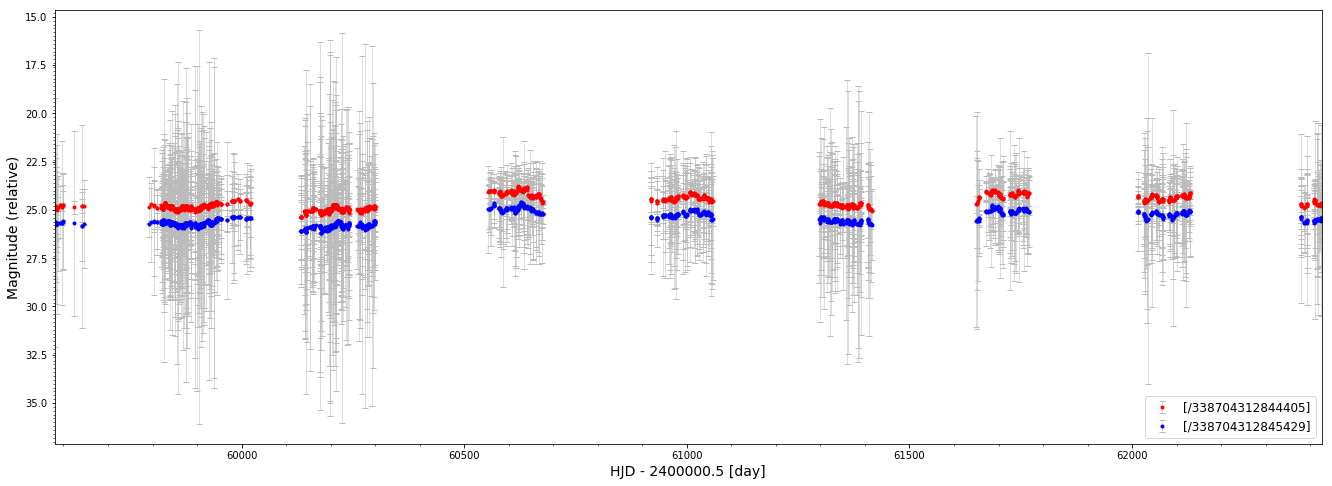

In [16]:
pycs.gen.lc.display(lcs, figsize=(20, 7), jdrange=(59580, 62426))

In [19]:
def spl(lcs):
    spline = pycs.spl.topopt.opt_rough(lcs, nit=5, knotstep=60, verbose=False) #50, 30, 20
    for l in lcs:
        l.resetml()
    spline = pycs.spl.topopt.opt_rough(lcs, nit=5, knotstep=40, verbose=False)
    spline = pycs.spl.topopt.opt_fine(lcs, nit=10, knotstep=30, verbose=False)
    return spline

In [20]:
%%capture
spline = spl(lcs)

In [21]:
basic_time_delays = pycs.gen.lc.getnicetimedelays(lcs, separator="\n", sorted=True)
print("Time Delays (no microlensing):")
print(basic_time_delays)

Time Delays (no microlensing):
338704312844405338704312845429 =   -5.69


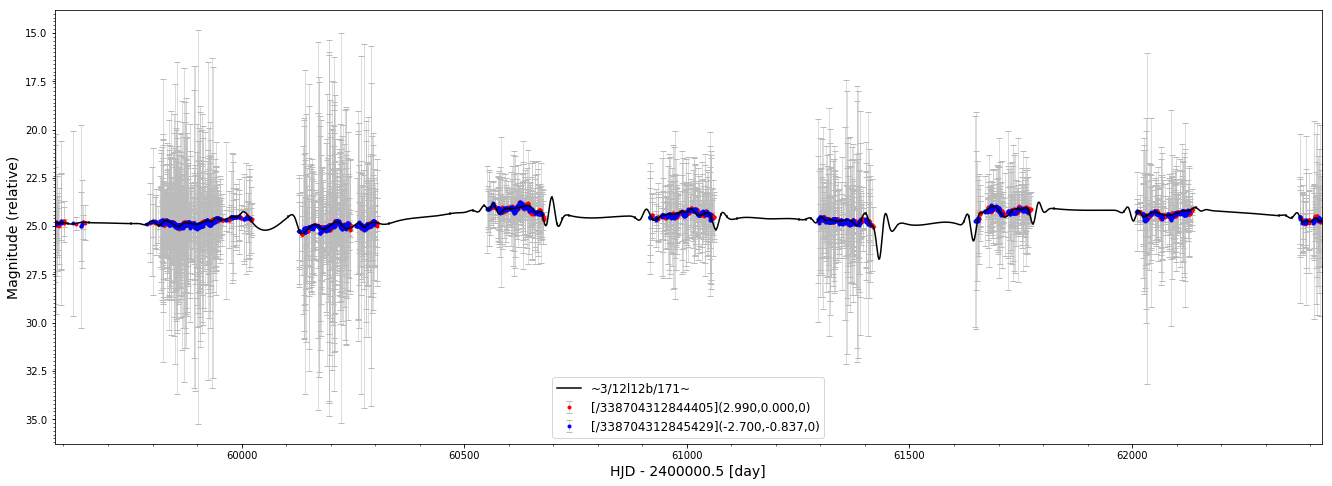

In [22]:
pycs.gen.lc.display(lcs, [spline], knotsize=0.01, figsize=(20, 7), jdrange=(59580, 62426))

In [23]:
pycs.gen.util.writepickle((lcs, spline), "optspline.pkl")

Wrote optspline.pkl


In [24]:
%%capture
n, npkl = 1, 20
Ncopies = n*npkl
print("Making",Ncopies,"copies of the original dataset:")
pycs.sim.draw.multidraw(lcs, onlycopy=True, n=n, npkl=npkl, simset="copies")

In [25]:
(modellcs, modelspline)  = pycs.gen.util.readpickle("optspline.pkl")

Read optspline.pkl


In [26]:
def Atweakml(lcs):
    return pycs.sim.twk.tweakml(lcs, beta=-1.5, sigma=0.25, fmin=1/500.0, fmax=None, psplot=False)

def Btweakml(lcs):
    return pycs.sim.twk.tweakml(lcs, beta=-1.0, sigma=0.9, fmin=1/500.0, fmax=None, psplot=False)

def Ctweakml(lcs):
    return pycs.sim.twk.tweakml(lcs, beta=-1.0, sigma=1.5, fmin=1/500.0, fmax=None, psplot=False)

def Dtweakml(lcs):
    return pycs.sim.twk.tweakml(lcs, beta=-0.0, sigma=4.5, fmin=1/500.0, fmax=None, psplot=False)

In [28]:
%%capture
n, npkl = 1, 20
Nmocks = n*npkl
truetsr = 8.0
print("Making",Nmocks,"synthetic datasets, varying time delays by +/-",truetsr/2.0,"days")
pycs.sim.draw.saveresiduals(modellcs, modelspline)
pycs.sim.draw.multidraw(modellcs, modelspline, n=n, npkl=npkl, simset="mocks",
        truetsr=truetsr, tweakml=[Atweakml, Btweakml])

In [31]:
%%capture
pycs.sim.run.multirun("copies", lcs, spl, optset="spl", tsrand=10.0, keepopt=True, verbose=False)

In [32]:
%%capture
tsrand = 1.0
pycs.sim.run.multirun("mocks", lcs, spl, optset="spl", tsrand=tsrand, keepopt=True, verbose=False)

Reading 18 runresult pickles...
OK, I have collected 18 runs from Free-knot spline technique
Wrote sims_copies_opt_spl_delays.pkl
Plotting "Free-knot spline technique (Measured, 18) "
     Labels : 338704312844405, 338704312845429
     Median shifts : 6.02, 0.43
     Std shifts : 2.96, 2.98


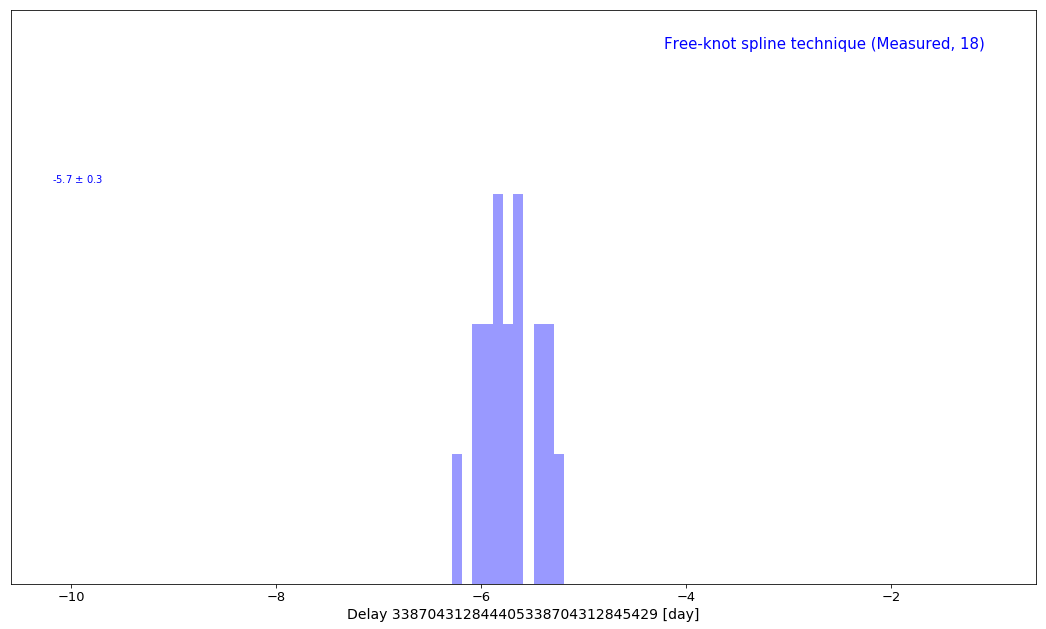

In [33]:
dataresults = [
        pycs.sim.run.collect("sims_copies_opt_spl", "blue", "Free-knot spline technique")
]
pycs.sim.plot.hists(dataresults, r=5.0, nbins=100, showqs=False,
        filename="fig_intrinsicvariance.pdf", dataout=True)

Reading 20 runresult pickles...
OK, I have collected 20 runs from Free-knot spline technique
Wrote sims_mocks_opt_spl_errorbars.pkl


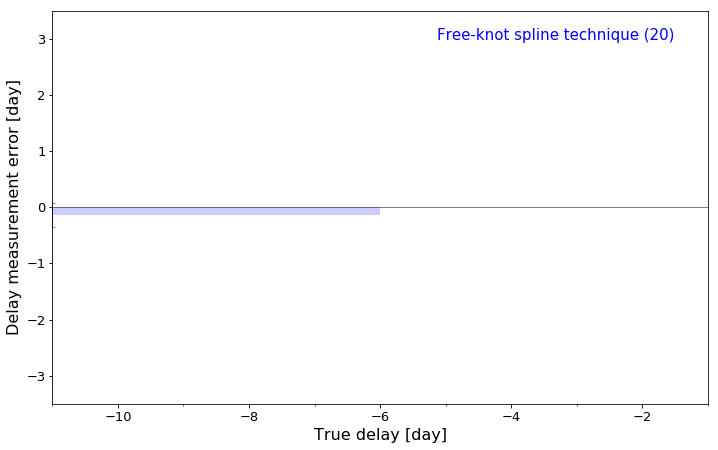

In [34]:
simresults = [
        pycs.sim.run.collect("sims_mocks_opt_spl", "blue", "Free-knot spline technique")
]
pycs.sim.plot.measvstrue(simresults, errorrange=3.5, r=5.0, nbins = 1, binclip=True, binclipr=20.0,
        plotpoints=False, filename="fig_measvstrue.pdf", dataout=True)


In [35]:
pycs.sim.plot.covplot(simresults, filename="fig_covplot.pdf")

Read sims_copies_opt_spl_delays.pkl
Read sims_mocks_opt_spl_errorbars.pkl
Objects : 338704312844405, 338704312845429
Delays : Free-knot spline technique <-> Errors : Free-knot spline technique
################################################################################
           Delay 338704312844405338704312845429
                   Free-knot spline technique :  -5.72 +/- 0.26 (0.22, 0.14)
################################################################################


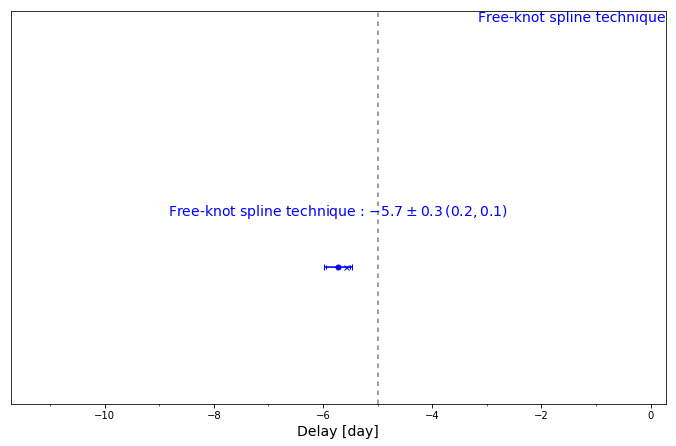

In [38]:
dataresults = [(pycs.gen.util.readpickle("sims_copies_opt_spl_delays.pkl"),
               pycs.gen.util.readpickle("sims_mocks_opt_spl_errorbars.pkl"))]
pycs.sim.plot.newdelayplot(dataresults, rplot=6.0, displaytext=True,
        filename = "fig_delays.pdf", refshifts=[{"colour":"gray", "shifts":(0, -5, -20, -70)}])

Results
=======

Write about your results here! Or don't!

Conclusions
===========

Write about your conclusions here. You have drawn some, right?